In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import random
import cmath
import math

# Define our buildDataSet function here!

In [3]:
def buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,data_set_size):
    sparse_data = np.zeros((vector_size,data_set_size)) # Initialize the sparse_data matrix

    # Iterate over the columns of the sparse_data matrix to define the data samples
    for i in range(data_set_size):
        sparsity = random.randint(min_sparsity,max_sparsity)
        indices = random.sample(range(vector_size),sparsity)
        amps = random.sample(range(max_amplitude),sparsity)
        sparse_data[indices,i] = amps
    
    # Define the DFT matrix and multiply our spare_data vectors with it to find dense data
    DFT = sp.linalg.dft(vector_size)/np.sqrt(vector_size)
    dense_data = DFT@sparse_data
    return dense_data,sparse_data


## Build the dataset

In [31]:
max_amplitude = 10
min_sparsity = 3
max_sparsity = 5
vector_size = 10
data_set_size = 1000
dense_data, sparse_data = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,data_set_size)


## Test the dataset

In [32]:
DFT = sp.linalg.dft(vector_size)/np.sqrt(vector_size)
iDFT = DFT.conj().T

print(iDFT@dense_data)


[[ 5.00000000e+00-2.23518715e-15j  4.00000000e+00-1.44313671e-15j
   1.46764599e-16-1.25146474e-15j ...  3.78551504e-15-2.14895238e-15j
   9.61767902e-17-1.02689549e-15j  9.14935862e-16-1.00383460e-15j]
 [-3.66898807e-16-2.07830942e-15j -1.53687865e-15-6.44429953e-16j
  -1.07023427e-15-4.11940447e-16j ...  1.55355586e-15-2.25993198e-15j
  -6.19915240e-16+3.54273213e-16j -1.27927433e-16-1.34832585e-15j]
 [-2.66453526e-15-8.85500009e-16j -1.57715381e-15+1.54853615e-16j
  -1.09788433e-15-8.91815805e-16j ... -6.92830175e-16-9.38654217e-16j
  -5.80339814e-16-4.28016803e-16j  2.00000000e+00-2.76901764e-16j]
 ...
 [ 8.00000000e+00+4.41185076e-16j  3.00000000e+00+8.42984995e-16j
   7.00000000e+00+1.38572257e-16j ...  2.97660417e-16+4.09085237e-17j
   4.00000000e+00-5.10851993e-17j  2.47059910e-16-4.61017022e-16j]
 [ 9.00000000e+00+1.12007387e-16j -2.05955365e-15+8.85248255e-16j
   3.86557041e-16+3.94023370e-17j ...  6.00000000e+00+8.37867620e-16j
  -1.89471288e-15+4.25364090e-16j  6.00000000e+

From the above results, we can see that our vectors are very sparse if we take the IDFT

## Setting up the dataset for Pytorch

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split

X = np.array([(data.real, data.imag) for data in dense_data]).T
Y = np.array([(data.real, data.imag) for data in sparse_data]).T

X_tensor = torch.tensor(X,dtype=torch.float)
Y_tensor = torch.tensor(Y,dtype=torch.float)
dataset = TensorDataset(X_tensor,X_tensor)

dataloader = DataLoader(dataset,batch_size = 100,shuffle = True, )
print(X_tensor.shape)

torch.Size([1000, 2, 10])


## Setting up the neural network

In [74]:
# class ExponentialComplexLinear(nn.Module):
#     def __init__(self, in_features, out_features):
#         super(ExponentialComplexLinear, self).__init__()
#
#         # Trainable phase angles (real-valued), this is where we are training the q-values) in the context of the exercise
#         self.phases = nn.Parameter(torch.randn(out_features, in_features) * 0.1)  # Small random initialization
#
#     def forward(self, x):
#         # Compute our matrix
#         W = torch.exp(1j * self.phases)  # Enforces |W| = 1
#
#         # Complex matrix multiplication)
#         return torch.matmul(x, W.t())

# class ComplexDecoder(nn.Module):
#     def __init__(self, encoding_dim, output_dim):
#         super(ComplexDecoder, self).__init__()
#
#         self.layers = nn.Sequential(
#             nn.Linear(200,400),
#             nn.ReLU(),
#             nn.Linear(400,400),
#             nn.ReLU(),
#             nn.Linear(400,200),
#             nn.Sigmoid()
#         )
#
#     def forward(self, x):
#         return self.layers(x)


class LearnedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(LearnedAutoencoder, self).__init__()
        compression_factor = input_dim / encoding_dim
        layer_size_factor = int(encoding_dim * compression_factor / 4)

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            # nn.Linear(int(input_dim/2), int(input_dim/4)),
            nn.Linear(input_dim, encoding_dim),
        )


        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            # nn.Linear(int(input_dim/2), input_dim),
            nn.Linear(input_dim, input_dim),
        )

    def forward(self, x):
        encoder_out = self.encoder(x)
        return self.decoder(encoder_out)

# class LearnedAutoencoder(nn.Module):
#     def __init__(self, input_dim, encoding_dim):
#         super(LearnedAutoencoder, self).__init__()
#         compression_factor = input_dim / encoding_dim
#         layer_size_factor = int(encoding_dim * compression_factor / 4)
#
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, 15),
#             nn.ReLU(),
#             nn.Linear(17, 15),
#             nn.ReLU(),
#             nn.Linear(15, 12),
#             nn.ReLU(),
#             nn.Linear(12, 10),
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(10, 12),
#             nn.ReLU(),
#             nn.Linear(12, 15),
#             nn.ReLU(),
#             nn.Linear(15, 17),
#             nn.ReLU(),
#             nn.Linear(17, input_dim),
#             nn.ReLU()
#         )
#
#     def forward(self, x):
#         encoder_out = self.encoder(x)
#         return self.decoder(encoder_out)


## Training the model

Epoch 1, Loss: 4.039172
Epoch 2, Loss: 2.960976
Epoch 3, Loss: 2.123206
Epoch 4, Loss: 1.723668
Epoch 5, Loss: 1.279506
Epoch 6, Loss: 0.875069
Epoch 7, Loss: 0.882880
Epoch 8, Loss: 0.665596
Epoch 9, Loss: 0.492486
Epoch 10, Loss: 0.448341
Epoch 11, Loss: 0.435646
Epoch 12, Loss: 0.477178
Epoch 13, Loss: 0.412785
Epoch 14, Loss: 0.422901
Epoch 15, Loss: 0.404281
Epoch 16, Loss: 0.352188
Epoch 17, Loss: 0.419862
Epoch 18, Loss: 0.407224
Epoch 19, Loss: 0.438521
Epoch 20, Loss: 0.409083
Epoch 21, Loss: 0.283346
Epoch 22, Loss: 0.142006
Epoch 23, Loss: 0.044531
Epoch 24, Loss: 0.018278
Epoch 25, Loss: 0.004486
Epoch 26, Loss: 0.001116
Epoch 27, Loss: 0.000270
Epoch 28, Loss: 0.000107
Epoch 29, Loss: 0.000068
Epoch 30, Loss: 0.000040
Epoch 31, Loss: 0.000014
Epoch 32, Loss: 0.000006
Epoch 33, Loss: 0.000002
Epoch 34, Loss: 0.000001
Epoch 35, Loss: 0.000000
Epoch 36, Loss: 0.000000
Epoch 37, Loss: 0.000000
Epoch 38, Loss: 0.000000
Epoch 39, Loss: 0.000000
Epoch 40, Loss: 0.000000
Epoch 41,

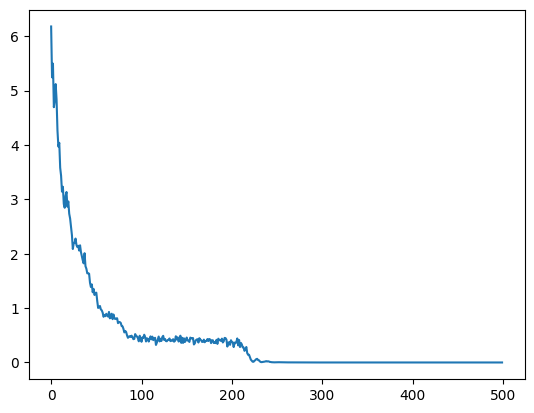

In [84]:
# Define the size of our "measurement" vector as encoding_dim. This needs to be larger than the sparsity of our matrix

# encoding_dim = max_sparsity
encoding_dim = 10
# Initialize model
model = LearnedAutoencoder(vector_size, encoding_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1E-2, weight_decay=1E-6)
loss_fn = nn.MSELoss()

# def complex_mse_loss(input, target):
#     return F.mse_loss(input, target)

# Training loop
losses = []
for epoch in range(50):
    for batch in dataloader:
        inputs, targets = batch  # Unpack the tuple
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

plt.plot(losses)
plt.show()

In [85]:
print(output[-1] - targets[-1])


tensor([[-4.2915e-06,  2.1458e-06, -1.1325e-06,  5.9605e-08,  3.0994e-06,
          3.0994e-06,  3.8147e-06, -2.9802e-07, -1.4901e-06,  2.8610e-06],
        [ 3.1590e-06, -7.1526e-07, -4.1723e-07, -6.6757e-06,  1.7881e-06,
         -2.3888e-07,  2.3842e-07,  6.1989e-06,  2.2650e-06,  2.3842e-06]],
       grad_fn=<SubBackward0>)
